# Identification of corn leaf Diseases Using a deep convolutional neural network architecture by transfer learning


## **Goal**
Build a web application to identify automatically images from corn leaves as healthy and unhealthy (Blights, Common Rust, and Gray Leaf Spot).

## **Objectives**

- Build a Deep Convolutional Neural Network(Xception) algorithm by transfer learning technique.

- Fine-Tuning the model.

- Deploy the model in a web application.


![alt text](https://static.country-guide.ca/wp-content/uploads/2016/04/March-III-2016-Headin_opt.jpeg)

<a href = "https://www.country-guide.ca/crops/the-crop-disease-in-corn-to-watch-for/">image source</a>


Author: Luis Fernando Salazar Salinas Date: 28/10/2021

## **Plant Village Dataset**

- The plant-Village dataset contains 39 different classes of plant leaf(healthy and unhealthy) and background images(61,486 in total)(Geetharamani & Pandian,2019). In this project,  we use the version without augmentation and just used the corn dataset, which contained four different classes (Blight, Common rust, Gray Leaf Spot, and Healthy).

In [ ]:
## Import libraries
import warnings
warnings.simplefilter(action='ignore')
import os 
import zipfile
from shutil import copyfile
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay


import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **Load the Dataset**

- Load and extract the dataset 
- Create train and test files 
- Split and assign the data into train, validation and test folders(80:10:10)
- Display some images

In [ ]:
## Conection with Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Load and extract the dataset
input_path = "/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease.zip"

local_zip = input_path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/Plant_Village_Dataset_Corn')
zip_ref.close()

In [ ]:
extrac_path = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/'

for set_ in ['data']:
    n_blight = len(os.listdir(extrac_path+set_ + '/Blight'))
    n_common_rust = len(os.listdir(extrac_path+set_ + '/Common_Rust'))
    n_gray_leaf_spot = len(os.listdir(extrac_path+set_ + '/Gray_Leaf_Spot'))
    n_health = len(os.listdir(extrac_path+set_ + '/Healthy'))
    print('blight images: {}, common rust images: {}, gray leaf spot images: {}, healt images:{}'.format(n_blight,
                                                                                                         n_common_rust,
                                                                                                         n_gray_leaf_spot,
                                                                                                         n_health))

blight images: 1146, common rust images: 1306, gray leaf spot images: 574, healt images:1162


In [ ]:
##Create train and test files
try:
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Healthy')

    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Healthy')

    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Healthy')
except OSError:
    print(file)

#### **Split and assign the data into train, validation and test folders(80:10:10)**

In [ ]:
#Split and assign the data into train and test files(80:20)
def split_data(SOURCE, TRAINING, VALIDATION, TESTING):
    
    all_files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name
        
        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    n_files = len(all_files)
    split_point_1 = round(n_files * 0.8)
    split_point_2 = round(n_files * 0.9)

    shuffled = random.sample(all_files, n_files)
    
    train_set = shuffled[:split_point_1]
    val_set = shuffled[split_point_1:split_point_2]
    test_set = shuffled[split_point_2:]
    
    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)
    
    for file_name in val_set:
        copyfile(SOURCE + file_name, VALIDATION + file_name)
        
    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)

Blight_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Blight/'
Common_Rust_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Common_Rust/'
Gray_Leaf_Spot_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Gray_Leaf_Spot/'
Healthy_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Healthy/'

TRAINING_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Blight/'
TRAINING_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Common_Rust/'
TRAINING_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Gray_Leaf_Spot/'
TRAINING_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Healthy/'

VALIDATION_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Blight/'
VALIDATION_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Common_Rust/'
VALIDATION_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Gray_Leaf_Spot/'
VALIDATION_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Healthy/'

TESTING_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Blight/'
TESTING_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Common_Rust/'
TESTING_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Gray_Leaf_Spot/'
TESTING_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Healthy/'


split_data(Blight_SOURCE_DIR, TRAINING_Blight_DIR, VALIDATION_Blight_DIR, TESTING_Blight_DIR)
split_data(Common_Rust_SOURCE_DIR, TRAINING_Common_Rust_DIR, VALIDATION_Common_Rust_DIR, TESTING_Common_Rust_DIR)
split_data(Gray_Leaf_Spot_SOURCE_DIR,TRAINING_Gray_Leaf_Spot_DIR, VALIDATION_Gray_Leaf_Spot_DIR, TESTING_Gray_Leaf_Spot_DIR)
split_data(Healthy_SOURCE_DIR,TRAINING_Healthy_DIR, VALIDATION_Healthy_DIR, TESTING_Healthy_DIR)

#### **Diplay some images**

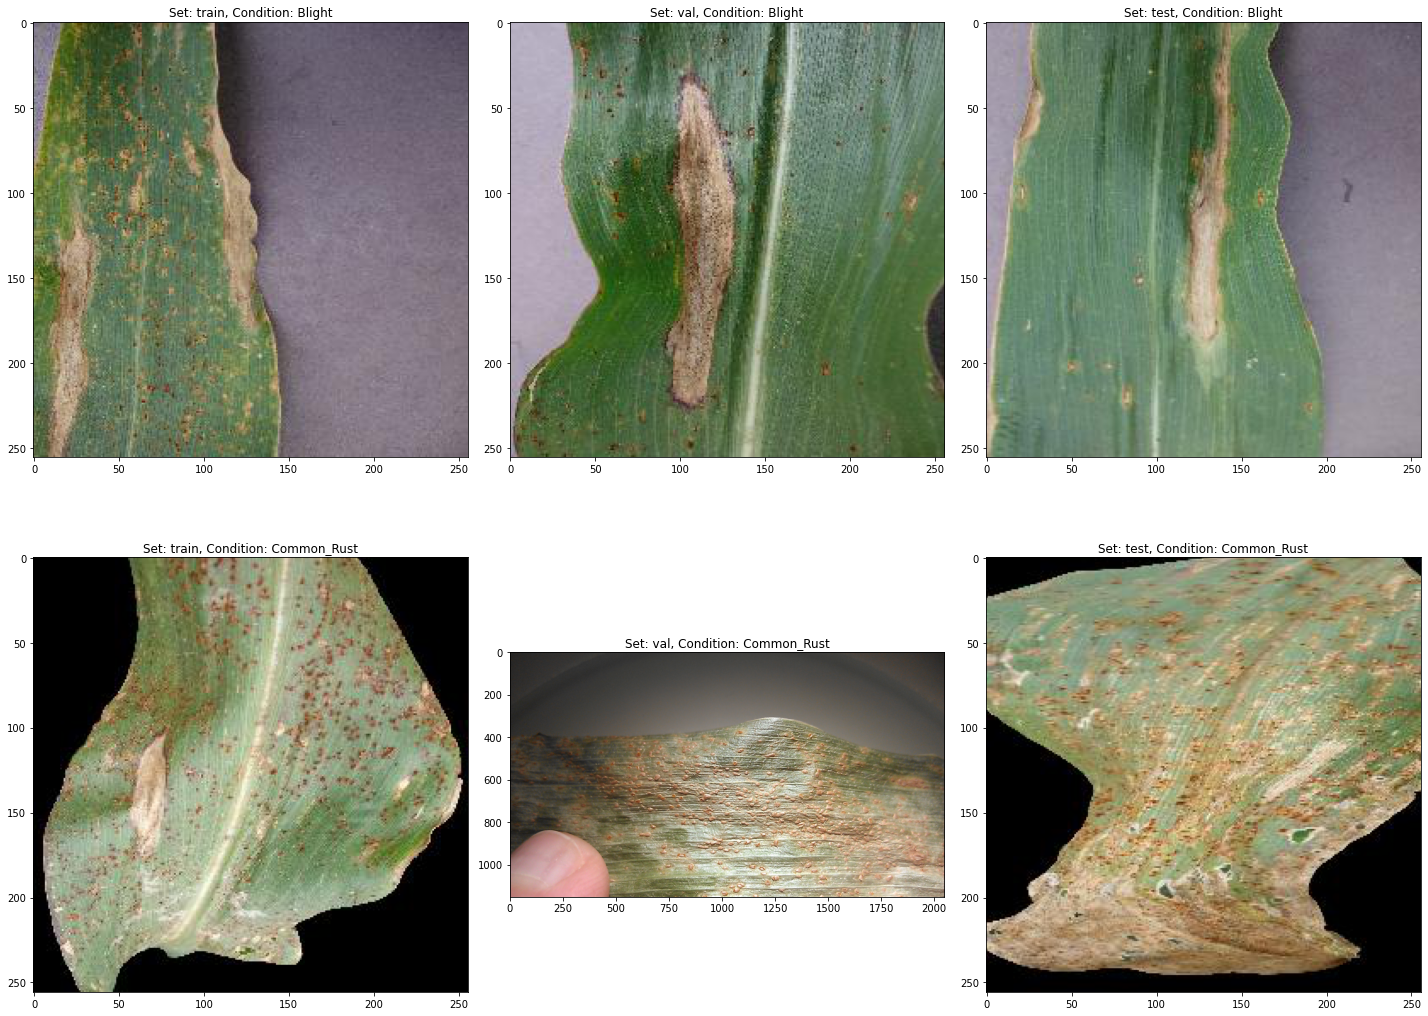

In [ ]:
##
path_ = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/'

fig, ax = plt.subplots(2,3,figsize=(20,15))
ax = ax.ravel()
plt.tight_layout()

for i, set_ in enumerate(['train','val', 'test']):
    set_path = path_+ set_
    ax[i].imshow(plt.imread(set_path+'/Blight/'+os.listdir(set_path+'/Blight')[0]))
    ax[i].set_title('Set: {}, Condition: Blight'.format(set_))
    ax[i+3].imshow(plt.imread(set_path+'/Common_Rust/'+os.listdir(set_path+'/Common_Rust')[0]))
    ax[i+3].set_title('Set: {}, Condition: Common_Rust'.format(set_))

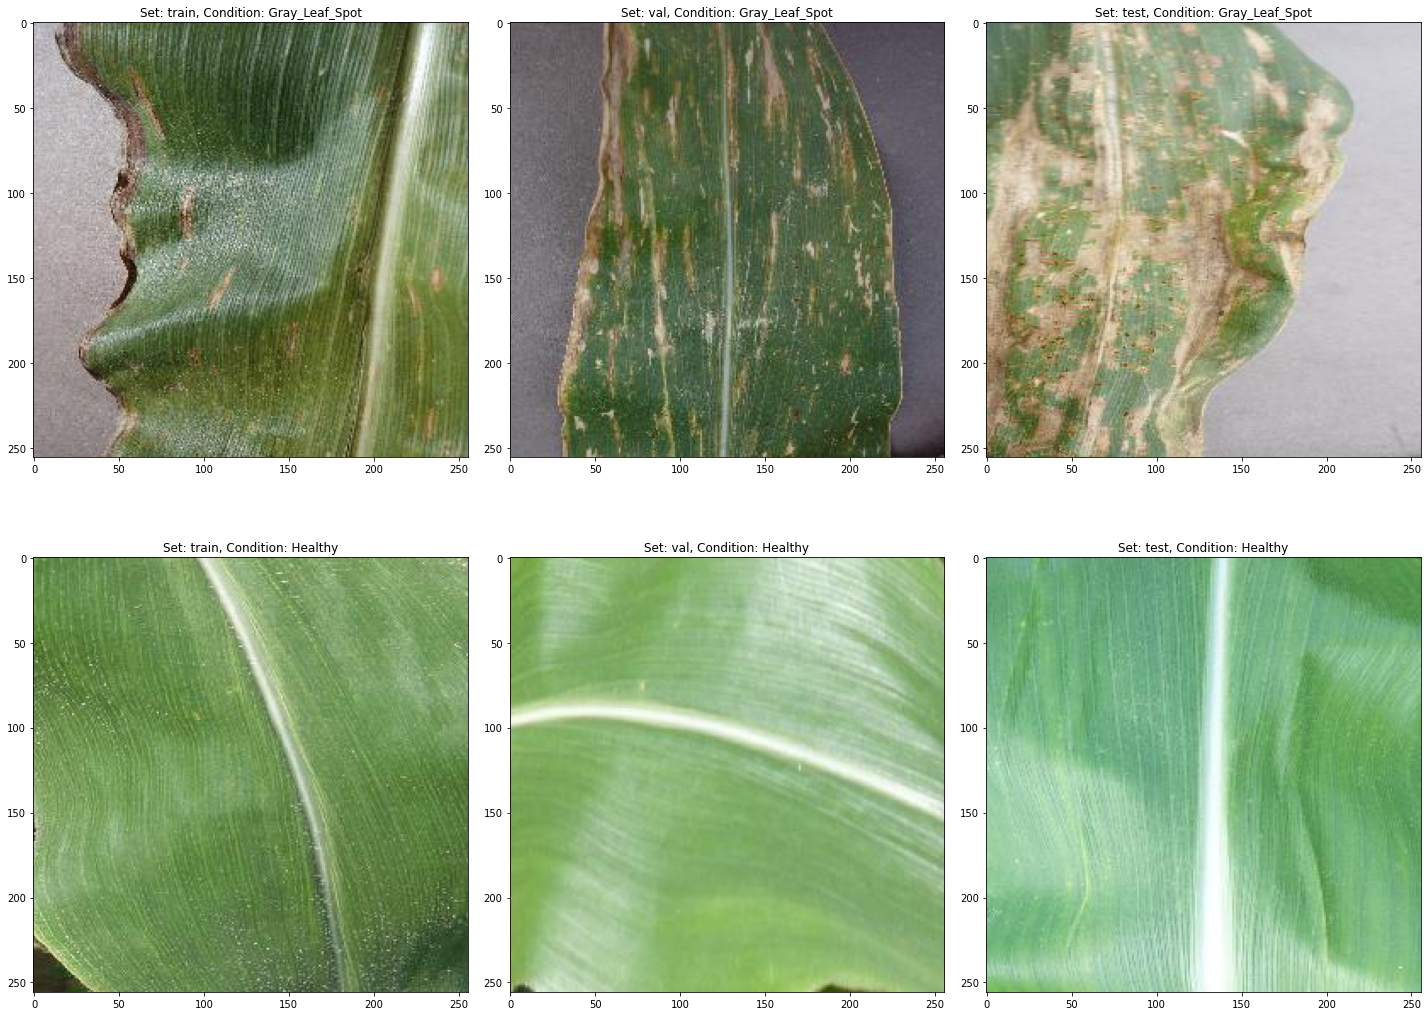

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(20,15))
ax = ax.ravel()
plt.tight_layout()

for i, set_ in enumerate(['train','val','test']):
    set_path = path_+ set_
    ax[i].imshow(plt.imread(set_path+'/Gray_Leaf_Spot/'+os.listdir(set_path+'/Gray_Leaf_Spot')[0]))
    ax[i].set_title('Set: {}, Condition: Gray_Leaf_Spot'.format(set_))
    ax[i+3].imshow(plt.imread(set_path+'/Healthy/'+os.listdir(set_path+'/Healthy')[0]))
    ax[i+3].set_title('Set: {}, Condition: Healthy'.format(set_))

## **Data preprocessing** 

- Split data into train and test set 
- Data normalization[0,1]
- Data augmentation using saveral techniques such as:
  - image flipping
  - zoom
  - shear 
  - width and height shift
  - image rotation
  - Image brightness range
  - Featurewise center
  - Featurewise std normalization
  
Note: the techniques of data augmentation were implemented using ImageDataGenerator from Keras. 

In [ ]:
def train_val_test_data(img_dims, batch_size):
  
  ## Training data
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                       rotation_range = 40,
                                       width_shift_range = .2,
                                       height_shift_range = .2,
                                       shear_range = .2,
                                       zoom_range = 0.3,
                                       horizontal_flip = True,
                                       vertical_flip=True,
                                       brightness_range=[0.5, 1.5],
                                       featurewise_center=True,
                                       featurewise_std_normalization=True,
                                       fill_mode = 'nearest',
                                   )
        
    
  ## Train generator
  train_gen = train_datagen.flow_from_directory(directory = path_ + 'train',
                                                  target_size = (img_dims, img_dims),
                                                  batch_size = batch_size,
                                                  class_mode = 'categorical',
                                                  shuffle = True)
  ## Validation Data
    
  validation_datagen = ImageDataGenerator(rescale = 1./255)
  ## validation generator
    
  val_gen = validation_datagen.flow_from_directory(directory = path_ + 'val',
                                                      target_size = (img_dims, img_dims),
                                                      batch_size = batch_size,
                                                      class_mode = 'categorical',
                                                      shuffle = True)
  
  
    
  return train_gen, val_gen

In [ ]:
img_dims = 224
batch_size = 128

train_gen, val_gen = train_val_test_data(img_dims, batch_size)

Found 3351 images belonging to 4 classes.
Found 418 images belonging to 4 classes.


## **Modeling** 

- Transfer leraning (Xception architecture)
- Fine-tuning


### **Transfer learning**
- Import Xception model pretrained with imaginet dataset
- Freezing all layers from Xception model
- Built a model with new top layers to classify 38 classes instead of 1000
- Training:
  - Epochs = 50
  - Adam optimizer with a 0.0001 base learning rate
- Model performance

In [ ]:
## Choose a device type (CPU or GPU)
devices = tf.config.list_physical_devices('GPU')
print(devices[0])

## Name divice
name_gpu = "GPU:0"

## Define my strategy like One Device Strategy 
strategy = tf.distribute.OneDeviceStrategy(device=name_gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


#### **Xception model**

- Xception is a convolutional neural network architecture base entirely on depthwise separable convolution layers.The architecture has 36 convolutional layers forming the feature extraction base of the network, the layers are structured into 14 modules, all of which have linear residual connections around them, except for the first and last module(Chollet, 2017). In other words, the Xception architecture is a linear stack of depthwise separable convolutional layers  with residual connections(Chollet, 2017).

![Xception architecture](https://miro.medium.com/max/1400/1*t6qfo9ucYza_lbLfg5-p_w.png)

Xception architecture image(Chollet, 2017)

In [ ]:
def xception():
  
  xception_m = tf.keras.applications.xception.Xception(input_shape=(img_dims,img_dims,3),
                                                               include_top = False,
                                                               weights = 'imagenet')
  x = xception_m.trainable = False
  x = xception_m.output

  x = GlobalAveragePooling2D()(x)
  out = Dense(4,activation='softmax')(x)
  
  model = Model(inputs = xception_m.inputs, outputs = out)

  model.summary() 

  return model

In [ ]:
with strategy.scope():

  xception_model = xception()
  xception_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = .0001),metrics = ['accuracy'])

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                      

### **Train the Xception model**

In [ ]:
epochs_1 = 50
history_1 = xception_model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size,
                               epochs=epochs_1, validation_data=(val_gen), 
                               validation_steps=val_gen.samples // batch_size
                                    )

Epoch 1/50
26/26 [==============================] - 1169s 44s/step - loss: 1.3583 - accuracy: 0.3720 - val_loss: 1.2607 - val_accuracy: 0.4375
Epoch 2/50
26/26 [==============================] - 60s 2s/step - loss: 1.1403 - accuracy: 0.5588 - val_loss: 1.0950 - val_accuracy: 0.5625
Epoch 3/50
26/26 [==============================] - 59s 2s/step - loss: 1.0034 - accuracy: 0.6736 - val_loss: 0.9632 - val_accuracy: 0.6562
Epoch 4/50
26/26 [==============================] - 60s 2s/step - loss: 0.8931 - accuracy: 0.7285 - val_loss: 0.8705 - val_accuracy: 0.7240
Epoch 5/50
26/26 [==============================] - 61s 2s/step - loss: 0.8090 - accuracy: 0.7667 - val_loss: 0.7937 - val_accuracy: 0.7396
Epoch 6/50
26/26 [==============================] - 60s 2s/step - loss: 0.7533 - accuracy: 0.7772 - val_loss: 0.7537 - val_accuracy: 0.7526
Epoch 7/50
26/26 [==============================] - 59s 2s/step - loss: 0.6999 - accuracy: 0.7884 - val_loss: 0.7024 - val_accuracy: 0.7656
Epoch 8/50
26/26 

#### **Xception model performance**
- loss and accuracy plot 
- Evaluation with the validation set
- Evaluation metrics:
 - Accuracy


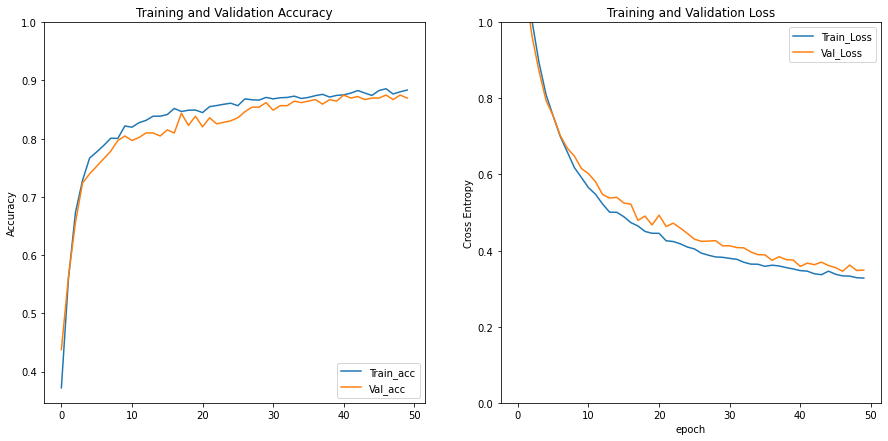

In [ ]:
### Loss and accuracy plot
acc_xcep = history_1.history['accuracy']
val_acc_xcep = history_1.history['val_accuracy']

loss_xcep = history_1.history['loss']
val_loss_xcep = history_1.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(acc_xcep, label='Train_acc')
plt.plot(val_acc_xcep, label='Val_acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_xcep, label='Train_Loss')
plt.plot(val_loss_xcep, label='Val_Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
result_eval = xception_model.evaluate(val_gen, verbose =0)

for metric, eval in zip(xception_model.metrics_names, result_eval):
  print(metric + ': {:.3}'.format(eval))

loss: 0.358
accuracy: 0.868


### **Fine-tuning the model**
- Un-freeze the top layers of Xception model
- training:
  - Total epochs = 65
  - Adam optimazer with a low learning rate (base_learning_rate/10) to avoid the overfitting 

In [ ]:
## Unfreezing layers
xception_model.trainable = True

In [ ]:
## Fine-tuning
## number of layer in the pre-trained model
print('Number of layer in the pre-trained model:{}'.format(len(xception_model.layers)))
fine_tune_at = 100

for layer in xception_model.layers[:fine_tune_at]:
  layer.trainable = False
print(f"Trainable Layers: {len(xception_model.trainable_variables)}")

Number of layer in the pre-trained model:134
Trainable Layers: 41


In [ ]:
with strategy.scope():
  
  xception_model.summary()
  xception_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.0001/10),metrics = ['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
## Training
fine_tune_epochs = 15
total_epochs = epochs_1 + fine_tune_epochs

history_fine = xception_model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size,
                                            epochs=total_epochs,
                                            initial_epoch = history_1.epoch[-1], 
                                            validation_data=(val_gen), 
                                            validation_steps=val_gen.samples // batch_size,
                                    )

Epoch 50/65
26/26 [==============================] - 67s 2s/step - loss: 0.6138 - accuracy: 0.8244 - val_loss: 0.3553 - val_accuracy: 0.8620
Epoch 51/65
26/26 [==============================] - 62s 2s/step - loss: 0.4799 - accuracy: 0.8638 - val_loss: 0.3496 - val_accuracy: 0.8646
Epoch 52/65
26/26 [==============================] - 64s 2s/step - loss: 0.4177 - accuracy: 0.8709 - val_loss: 0.3466 - val_accuracy: 0.8672
Epoch 53/65
26/26 [==============================] - 63s 2s/step - loss: 0.3688 - accuracy: 0.8793 - val_loss: 0.3427 - val_accuracy: 0.8724
Epoch 54/65
26/26 [==============================] - 63s 2s/step - loss: 0.3333 - accuracy: 0.8874 - val_loss: 0.3283 - val_accuracy: 0.8724
Epoch 55/65
26/26 [==============================] - 64s 2s/step - loss: 0.3070 - accuracy: 0.8945 - val_loss: 0.3168 - val_accuracy: 0.8776
Epoch 56/65
26/26 [==============================] - 63s 2s/step - loss: 0.2911 - accuracy: 0.8976 - val_loss: 0.2894 - val_accuracy: 0.8854
Epoch 57/65
2

#### **Fine-tuning model performance**
- loss and accuracy plot
- Evaluate with the validation set
- Metrics:
 - Accuracy
 

In [ ]:
acc_xcep += history_fine.history['accuracy']
val_acc_xcep += history_fine.history['val_accuracy']

loss_xcep += history_fine.history['loss']
val_loss_xcep += history_fine.history['val_loss']


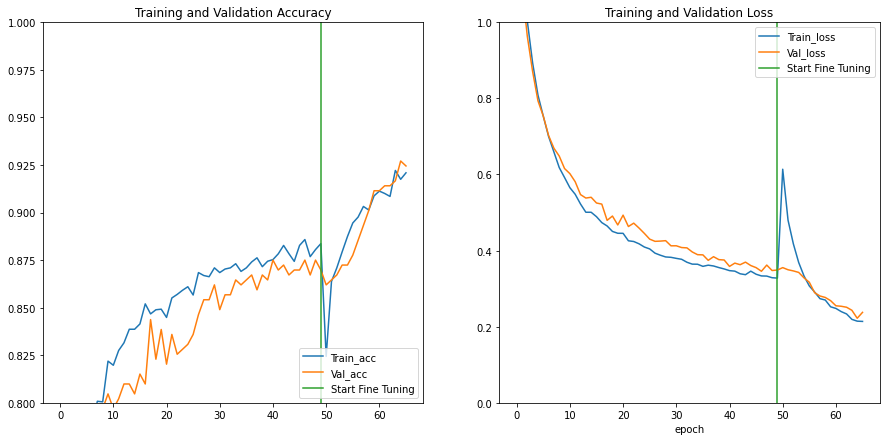

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(acc_xcep, label='Train_acc')
plt.plot(val_acc_xcep, label='Val_acc')
plt.ylim([0.8, 1])
plt.plot([epochs_1-1,epochs_1-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_xcep, label='Train_loss')
plt.plot(val_loss_xcep, label='Val_loss')
plt.ylim([0, 1.0])
plt.plot([epochs_1-1,epochs_1-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
result_eval_f = xception_model.evaluate(val_gen, verbose =0)

for metric_, eval_ in zip(xception_model.metrics_names, result_eval_f):
  print(metric_ + ': {:.3}'.format(eval_))

loss: 0.231
accuracy: 0.923


##### **Observations**

- The model with the transfer learning technique reaches a good performance(accuracy = 0.864).

- Unfreezing some layers (fine-tuning) give more performance to the model, reaching an accuracy = 0.92 and loss = 0.174 

### **Model Evaluation with the test set**

In [ ]:
## Import the test set
input_test = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test'
labels = os.listdir(input_test)
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_dims, img_dims)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
test_set_ = get_data(input_test)

## X and y test
X_test, y_test = [],[]
for feature, labels in test_set_:
  X_test.append(feature)
  y_test.append(labels)
## Convert the data in arrays 
X_test = np.array(X_test) / 255
y_test = np.array(y_test)

In [ ]:
## Prediction 
y_pred = np.argmax(xception_model.predict(X_test), axis = -1)

Accuracy: 0.931%


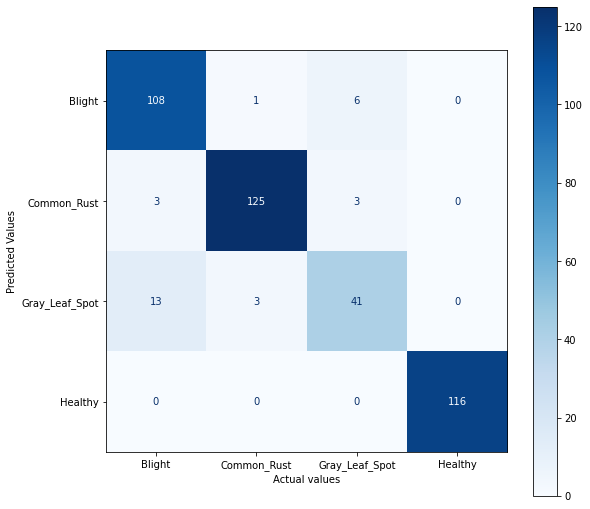

In [ ]:
from sklearn.metrics import accuracy_score

#print("CONFUSION MATRIX ------------------------------")
fig, ax = plt.subplots(figsize=(9,9))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', ax = ax)
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted Values")
ax.xaxis.set_ticklabels(["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"])
ax.yaxis.set_ticklabels(["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"])

## Accuracy and F1-Score
acc_x = accuracy_score(y_test, y_pred)

print(f'Accuracy: {round(acc_x, 3)}%')

### **Final Observations**

- In general, the model reaches quite good performance with the test set, achieving an Accuracy of 93% .

- By analysing the Confusion Matrix, we can see that the model is so good at identifying Healthy leaf images (116 out of 116) and Common Rust leaf image ( 125 out of 129) with 100% and 96.8%  images correctly classified repeclty. On the other hand, the model with respect the other classes reached a performance aceptable, with 87.1% images correctly classified for Blight leaf  and 82% for Grey leaf spot.

### **Save the Xception model**

In [ ]:
## Save model in HDF5 format
export_path = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/save_model/Xceptio_model'
xception_model.save(export_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Plant_Village_Dataset_Corn/save_model/Xceptio_model/assets
